# EDA of Correlations within Data

In [1]:
import h5py

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('../histograms.mplstyle')

import scipy.stats
import scipy.optimize

from matplotlib         import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator
from math import pi

In [2]:
PLOT_PATH   = "./plots/"
PLOT_PREFIX = "correlations_"
PLOT_EXT    = ".png"

## Brief data inspection

In [5]:
# path to data file
FILE_NAME = "../data/RUN000054_1_channels.h5"
# get keys
f = h5py.File(FILE_NAME, "r")
keys = f.keys()

# build the dataset by concatenating all channels together
df = pd.concat(
    [
        pd.read_hdf(FILE_NAME, key=k, mode="r") for k in keys
    ],
    ignore_index=True
)

# rename columns
df = df.rename(columns={"CH":"ch", "HIT_DRIFT_TIME":"drift_time", "THETA":"theta", "D_WIRE_HIT":"d_wire"})

print(f"Shape: {df.shape}")
print(f'Features: {list(df.columns)}')

Shape: (1059979, 5)
Features: ['ch', 'drift_time', 'd_wire', 'm', 'theta']


### Visualization

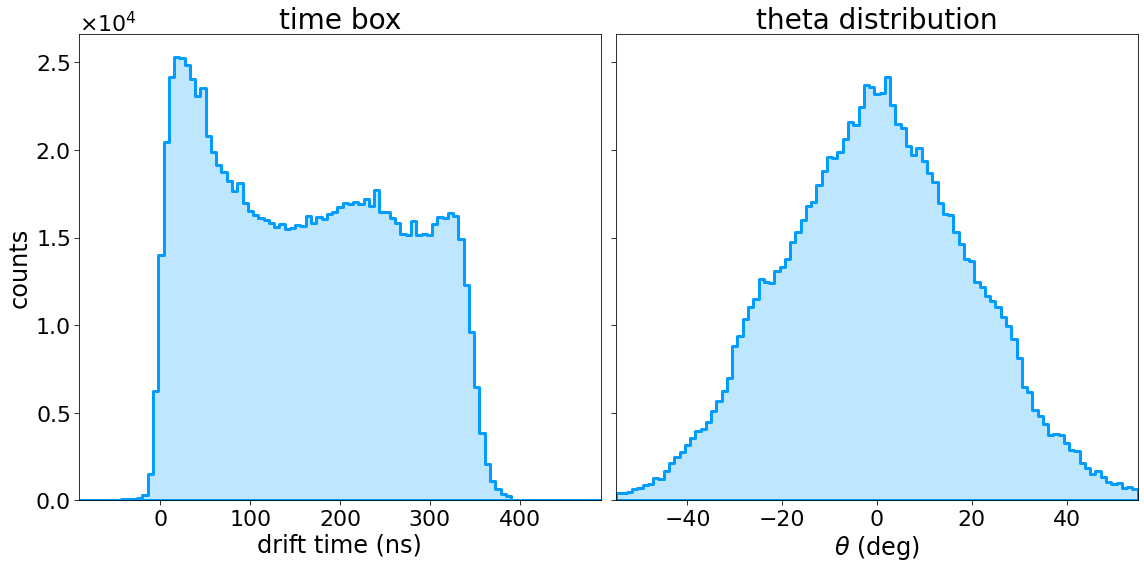

In [6]:
# BINS:
# drift time
dt_bins    = np.linspace(-90, 490, 100)
# theta
theta_bins = np.linspace(-55, 55 ,100)

fig, ax = plt.subplots(ncols=2, figsize=(16,8), sharey=True)

ax[0].set_title("time box")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("counts")

ax[1].set_title("theta distribution")
ax[1].set_xlabel(r"$\theta$ (deg)")
# ax[1].set_ylabel("density")

ax[0].set_xlim(dt_bins[0], dt_bins[-1])
ax[1].set_xlim(theta_bins[0], theta_bins[-1])

# drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = dt_bins,
    stat      = "count",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[0]
)

# theta distribution
sns.histplot(
    x         = df.theta,
    bins      = theta_bins,
    stat      = "count",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[1]
)

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[0].yaxis.get_offset_text().set_fontsize(22)

ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[1].yaxis.get_offset_text().set_fontsize(22)

ax[0].tick_params(axis="both", which="major", labelsize=22, length=5)
ax[1].tick_params(axis="both", which="major", labelsize=22, length=5)


fig.tight_layout()
PLOT_NAME = "distributions"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

### Scatterplot and Correlation coefficient

In [7]:
def plot_full_scatter(df, features):
    """scatterplot and profile plot of two features"""
    
    # perform a linear regression using scipy.stats.linregress
    reg_results = scipy.stats.linregress(df[features[0]], df[features[1]])

    # bin the x data
    bins = np.linspace(-200, 400, 12)
    # we add a column to our dataframe so we can use pandas.DataFrame.groupby()
    df["bin"] = np.digitize(df[features[0]], bins=bins)

    # bin centers
    x    = 0.5 * (bins[1:] + bins[:-1])
    # mean of y data inside each bin
    y    = df.groupby("bin")[features[1]].mean()
    # std of y data inside each bin
    erry = df.groupby("bin")[features[1]].std()
    
    xgrid = np.linspace(df[features[0]].min(), df[features[0]].max(), 300)
    
    fig, ax = plt.subplots(figsize=(14,8))
    
    ax.set_xlim(dt_bins[0], dt_bins[-1])
    ax.set_ylim(theta_bins[0], theta_bins[-1])
    
    ax.set_title("scatter theta vs drift time", fontsize=28)
    ax.set_xlabel("drift time (ns)", fontsize=24)
    ax.set_ylabel("theta (deg)", fontsize=24)
    
    ax.tick_params(axis="both", which="major", labelsize=22, length=5)
    

    ax.scatter(
        data      = df,
        x         = features[0],
        y         = features[1],
        color     = "#aadeff",
        edgecolor = "#009cff",
        alpha     = 0.7,
        label="data points"
    )
    
    ax.errorbar(
        x, 
        y, 
        yerr=erry, 
        color="black",
        ecolor ="black", 
        elinewidth=2,
        capsize=2,
        capthick=2,
        marker="o", 
        linestyle="",
        alpha=1,
        label = "profile", 
    )
    
    ax.plot(
        xgrid,    
        reg_results.intercept + reg_results.slope*xgrid, 
        color = "#ff6300", 
        linestyle = "dashed", 
        linewidth = 3, 
        label="regression"
    )
    
    ax.legend(loc="lower left", fontsize=24, bbox_to_anchor=(1, 0.5))
    df.drop(labels="bin", axis=1, inplace=True)
    
    return fig, ax

Correlation coefficient between drift time and theta: -0.02869
p-value = 8.180e-192
Statistically significant: YES


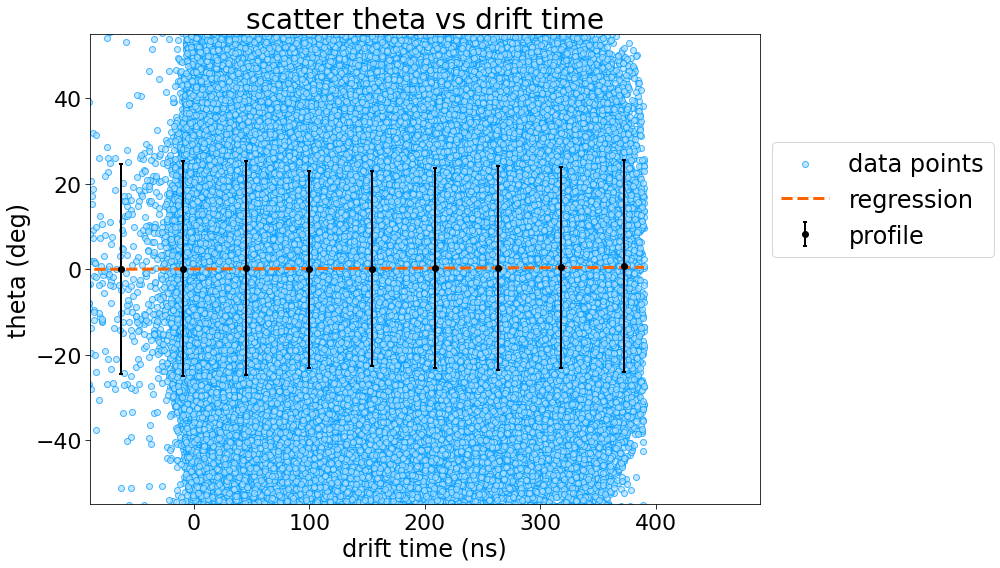

In [8]:
# correlation coefficient and its p-value
# note that I'm considering the absolute value of the angular feature:
# due to its simmetry I believe that we can get more statistical significance if we do so
r, p = scipy.stats.pearsonr(df.drift_time, np.abs(df.theta))
# set a confidence level at 5%
alpha = 0.05

print(f"Correlation coefficient between drift time and theta: {r:.5f}")
print(f"p-value = {p:.3e}")
print("Statistically significant:", "YES" if p < alpha else "NO")

fig, ax = plot_full_scatter(df=df, features=["drift_time", "theta"])
fig.tight_layout()
PLOT_NAME = "scatter"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)
plt.show()

### Covariance matrix

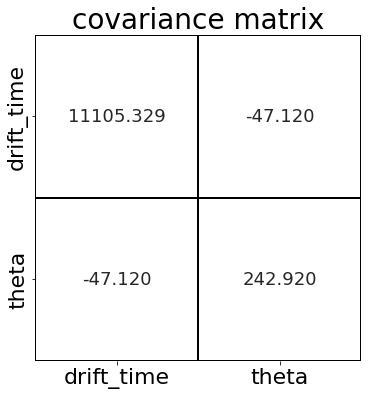

In [9]:
# covariance matrix
# note that I'm still considering the absolute value of theta
cov = np.cov([df.drift_time, np.abs(df.theta)])

textcolors = ["white", "black"]
ticklabels = ["drift_time","theta"]

fig, ax = plt.subplots(figsize=(6,6)) 
ax.set_title("covariance matrix")        

# plot of the covariance matrix
sns.heatmap(
    data        = cov,
    cmap        = ["white"],
    linecolor   = "black",
    linewidth   = 2,
    xticklabels = ticklabels, 
    yticklabels = ticklabels,
    robust      = True,
    annot       = True,
    fmt         = ".3f",
    annot_kws   = {"fontsize":18},
    cbar        = False,
    square      = True,
    ax          = ax
)

plt.show()

## Cutting the angular feature

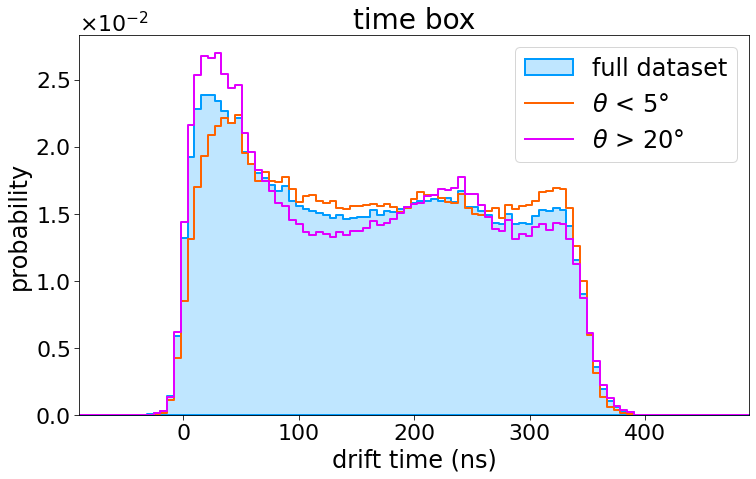

In [10]:
# binning drift time
bins = np.linspace(-90, 490, 100)
binwidth = bins[1] - bins[0]
bincenters = 0.5 * (bins[1:]+bins[:-1])

# CUTS:
# theta lower than |5°|
cut_1 = np.abs(df.theta) < 5
# theta higher than |20°|
cut_2 = np.abs(df.theta) > 20


fig, ax = plt.subplots(figsize=(12,7))

ax.set_title("time box", fontsize=28)
ax.set_xlabel("drift time (ns)", fontsize=24)
ax.set_ylabel("probability", fontsize=24)        # using probability instead of density

ax.set_xlim(bins[0], bins[-1])


# full dataset - drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 2,
    label     = "full dataset",
    ax        = ax
)

# theta lower than |5°| - drift time distribution
sns.histplot(
    x         = df[cut_1].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#ff6300",
    linewidth = 2,
    label     = r"$\theta$ < 5°",
    ax        = ax
)

# theta higher than |20°| - drift time distribution
sns.histplot(
    x         = df[cut_2].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#e200ff",
    linewidth = 2,
    label     = r"$\theta$ > 20°",
    ax        = ax
)



# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax.yaxis.get_offset_text().set_fontsize(22)
ax.tick_params(axis="both", which="major", labelsize=22, length=5)



ax.legend(fontsize=24)

PLOT_NAME = "simple_cut"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

## Possible breakthrough: correlation with cuts

In [11]:
def normalize(hist):
    """normalizes an histogram such that the sum of bin heights is equal to 1

    Args:
        hist      (np.ndarray): bin heights
        
    Return:
        norm_hist (np.ndarray): normalized bin heights
    """
    return (hist / np.sum(hist))

In [12]:
# list of selected values of theta 
thetas = np.arange(5, 55, 5)

# create a list of masks (cuts) that slices data if theta is less than the selected value
low_cuts = [
    np.abs(df.theta) < theta for theta in thetas
]
# create a list of masks (cuts) that slices data if theta is higher than the selected value
high_cuts = [
    np.abs(df.theta) > theta for theta in thetas
]

In [13]:
# bin the time box for each (low) cut value 
hists         = [np.histogram(df[cut].drift_time, bins=bins)[0] for cut in low_cuts]
low_hist_bins = [np.histogram( df[cut].drift_time, bins=bins )[1] for cut in low_cuts ]

low_norms     = [np.sum(h) for h in hists]
low_hists     = [normalize(h) for h in hists]
low_err       = [np.sqrt(h/n) for h,n in zip(low_hists,low_norms)]
# find the maximum of the left edge peak 
low_peaks     = [h.max() for h in low_hists]
low_peaks_err = [e.max() for e in low_err]      # HORRIBLE WAY TO SELECT THE CORRESPONDING UNCERTAINTY

# bin the time box for each (high) cut value 
hists          = [np.histogram(df[cut].drift_time, bins=bins)[0] for cut in high_cuts]
high_hist_bins = [np.histogram( df[cut].drift_time, bins=bins )[1] for cut in high_cuts ]

high_norms     = [np.sum(h) for h in hists]
high_hists     = [normalize(h) for h in hists]
high_err       = [np.sqrt(h/n) for h,n in zip(high_hists,high_norms)]
# find the maximum of the left edge peak 
high_peaks     = [h.max() for h in high_hists]
high_peaks_err = [e.max() for e in high_err]    # HORRIBLE WAY TO SELECT THE CORRESPONDING UNCERTAINTY



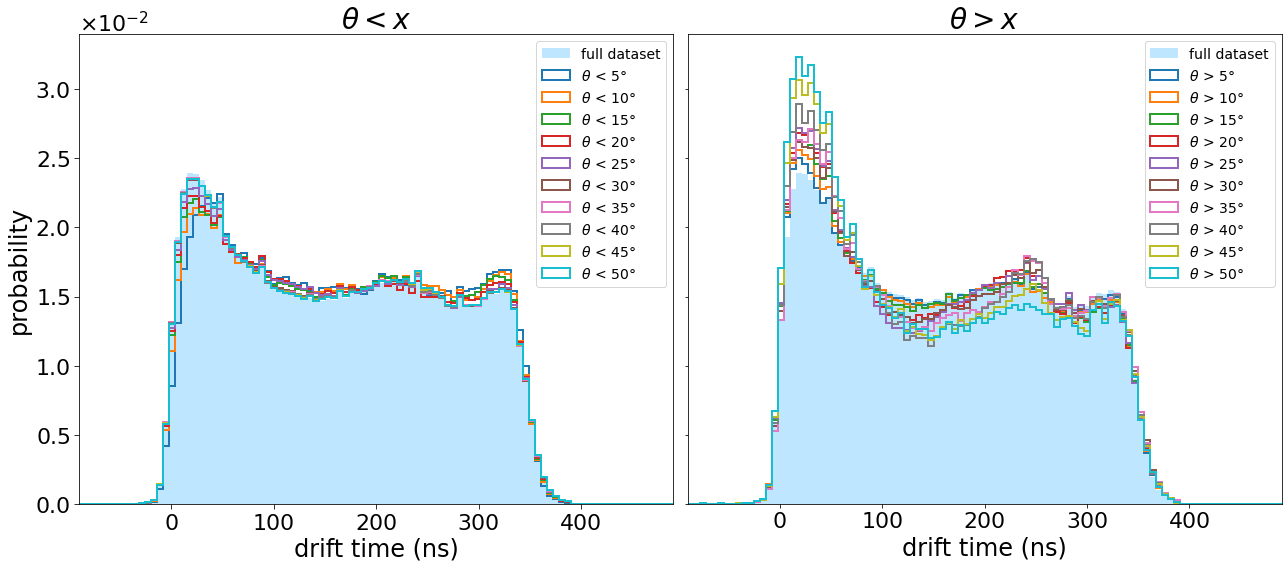

In [14]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(18,8))


ax[0].set_title(r"$\theta < x$")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("probability")
ax[1].set_title(r"$\theta > x$")
ax[1].set_xlabel("drift time (ns)")

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[0].yaxis.get_offset_text().set_fontsize(22)
ax[0].tick_params(axis="both", which="major", labelsize=22, length=5)


# x range
ax[0].set_xlim(bins[0], bins[-1])

# ------------------------------------
# FULL DATASETS FOR REFERENCE
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[0]
)
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[1]
)
# ------------------------------------

# low-cut time boxes
for h, theta in zip(low_hists, thetas):
    ax[0].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=r"$\theta$ < "+str(theta)+"°"
    )

# high-cut time boxes
for h, theta in zip(high_hists, thetas):
    ax[1].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=r"$\theta$ > "+str(theta)+"°"
    )


ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

fig.tight_layout()

PLOT_NAME = "timebox_shape"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

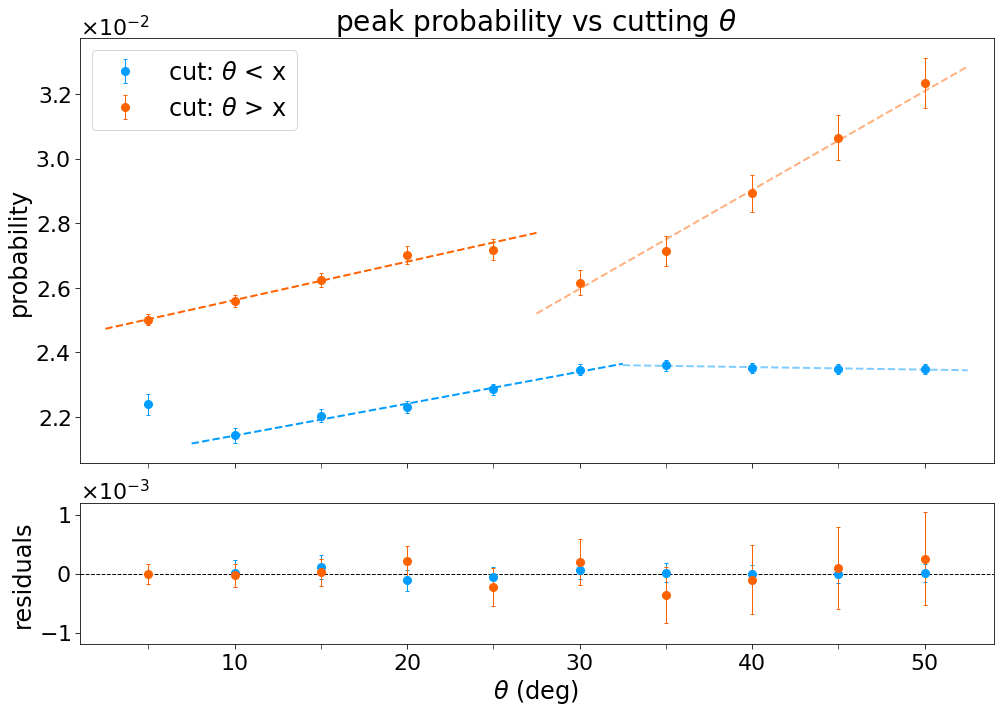

In [19]:
# linear function
def lin(x, a, b): return a + b*x

# x grid for theta values (continuous, employed in plotting the fitted function)
theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)

# fitting low cuts
low_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[1:6], 
    ydata=low_peaks[1:6],
    sigma=low_peaks_err[1:6], 
    absolute_sigma=True
)

# fitting high cuts
high_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[0:5], 
    ydata=high_peaks[0:5],
    sigma=high_peaks_err[0:5], 
    absolute_sigma=True
)

# residuals
func = lin(np.array(thetas[1:6]), *low_par)
low_res = low_peaks[1:6] - func
chi_low_small = np.sum( ( low_res ) / low_peaks_err[1:6] )**2

func = lin(np.array(thetas[0:5]), *high_par)
high_res = high_peaks[0:5] - func
chi_high_small = np.sum( ( high_res ) / high_peaks_err[0:5] )**2


# TO DO: perform goodness-of-fit test (easy chi2 test)

fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs cutting $\theta$", fontsize=28)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=24)
ax1.set_ylabel("probability", fontsize=24)
ax2.set_ylabel("residuals", fontsize=24)

ax1.set_xlim(theta_grid[0], theta_grid[-1])
ax2.set_xlim(theta_grid[0], theta_grid[-1])
# ax.set_ylim(0.01,0.039)


# exponential y ticks
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="x", which="minor", labelsize=0, length=5)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="x", which="minor", labelsize=0, length=5)

# ax1.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_ylim(-1.2e-3, 1.2e-3)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

# low-cut scatter
ax1.errorbar(
    x          = thetas, 
    y          = low_peaks,
    yerr       = low_peaks_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ < x"
)
# low-cut fit
ax1.plot(
    np.linspace(thetas[1]-2.5, thetas[5]+2.5, 100), 
    lin(np.linspace(thetas[1]-2.5, thetas[5]+2.5, 100), *low_par),
    linestyle = "dashed",
    color = "#009cff", 
    lw=2
)

# high-cut scatter
ax1.errorbar(
    x          = thetas, 
    y          = high_peaks,
    yerr       = high_peaks_err,
    marker     = "o",
    markersize = 8,
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)
# high-cut fit
ax1.plot(
    np.linspace(thetas[0]-2.5, thetas[4]+2.5, 100), 
    lin(np.linspace(thetas[0]-2.5, thetas[4]+2.5, 100), *high_par),
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2
)

# low-cut residuals
ax2.errorbar(
    x          = thetas[1:6], 
    y          = low_res,
    yerr       = low_peaks_err[1:6],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

# high-cut residuals
ax2.errorbar(
    x          = thetas[0:5], 
    y          = high_res,
    yerr       = high_peaks_err[0:5],
    marker     = "o",
    markersize = 8,
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ > x"
)




# fitting low cuts
low_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[6:], 
    ydata=low_peaks[6:],
    sigma=low_peaks_err[6:], 
    absolute_sigma=True
)

# fitting high cuts
high_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[5:], 
    ydata=high_peaks[5:],
    sigma=high_peaks_err[5:], 
    absolute_sigma=True
)

# residuals
func = lin(np.array(thetas[6:]), *low_par)
low_res = low_peaks[6:] - func
chi_low_large = np.sum( ( low_res ) / low_peaks_err[6:] )**2


func = lin(np.array(thetas[5:]), *high_par)
high_res = high_peaks[5:] - func
chi_high_large = np.sum( ( high_res ) / high_peaks_err[5:] )**2

# low-cut residuals
ax2.errorbar(
    x          = thetas[6:], 
    y          = low_res,
    yerr       = low_peaks_err[6:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

# high-cut residuals
ax2.errorbar(
    x          = thetas[5:], 
    y          = high_res,
    yerr       = high_peaks_err[5:],
    marker     = "o",
    markersize = 8,
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ > x"
)

# low-cut fit
ax1.plot(
    np.linspace(thetas[6]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[6]-2.5, thetas[-1]+2.5, 100), *low_par),
    linestyle = "dashed",
    color = "#009cff", 
    lw=2,
    alpha=0.5,
)
# high-cut fit
ax1.plot(
    np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), *high_par),
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=0.5,
)

PLOT_NAME = "cut_fit"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

ax1.legend(fontsize=24)

fig.tight_layout()
plt.show()




In [37]:
#residuals
# func = lin(np.array(thetas[1:6]), *low_par)
# low_res = low_peaks[1:6] - func
# # chi_low_small = 0
# # for i in range(len(func)):
# #     chi_low_small += ( low_peaks[i+1] - func[i] )**2 / low_peaks_err[i]


# func = lin(np.array(thetas[0:5]), *high_par)
# high_res = high_peaks[0:5] - func


# func = lin(np.array(thetas[6:]), *low_par)
# low_res = low_peaks[6:] - func


# func = lin(np.array(thetas[5:]), *high_par)
# high_res = high_peaks[5:] - func



# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
low_small_r,   low_small_p = scipy.stats.pearsonr(thetas[1:6], low_peaks[1:6])
low_large_r,   low_large_p = scipy.stats.pearsonr(thetas[6:], low_peaks[6:])

high_small_r, high_small_p = scipy.stats.pearsonr(thetas[0:5], high_peaks[0:5])
high_large_r, high_large_p = scipy.stats.pearsonr(thetas[5:], high_peaks[5:])

print("\nLOW CUT:")
print(f"Correlation coefficient (small theta) {low_small_r:.5f}")
print('Chi squared', chi_low_small)
print(f"p-value = {low_small_p:.2e}")
print("Statistically significant:", "YES" if low_small_p < alpha else "NO")

print(f"Correlation coefficient (large theta) {low_large_r:.5f}")
print('Chi squared', chi_low_large)
print(f"p-value = {low_large_p:.2e}")
print("Statistically significant:", "YES" if low_large_p < alpha else "NO")

print("\nHIGH CUT:")
print(f"Correlation coefficient (small theta) {high_small_r:.5f}")
print('Chi squared', chi_high_small)
print(f"p-value = {high_small_p:.2e}")
print("Statistically significant:", "YES" if high_small_p < alpha else "NO")

print(f"Correlation coefficient (large theta) {high_large_r:.5f}")
print('Chi squared', chi_high_large)
print(f"p-value = {high_large_p:.2e}")
print("Statistically significant:", "YES" if high_large_p < alpha else "NO")


LOW CUT:
Correlation coefficient (small theta) 0.99317
Chi squared 0.001319379724919204
p-value = 6.77e-04
Statistically significant: YES
Correlation coefficient (large theta) -0.95306
Chi squared 1.6806724967588319e-06
p-value = 4.69e-02
Statistically significant: YES

HIGH CUT:
Correlation coefficient (small theta) 0.98644
Chi squared 0.0018042760899152901
p-value = 1.89e-03
Statistically significant: YES
Correlation coefficient (large theta) 0.99575
Chi squared 0.0004039279885688102
p-value = 3.32e-04
Statistically significant: YES


# Intervalli $\theta_{low} < \theta_i < \theta_{up}$

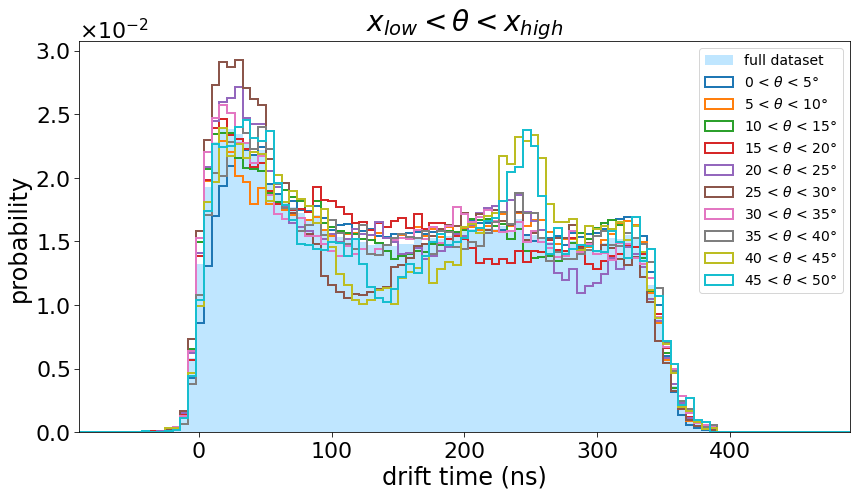

In [42]:
thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
bins = np.linspace(-90,490,100)

middle_cut = [ ( (np.abs(df["theta"]) > low ) & (np.abs(df["theta"]) < up ) ) for low, up in zip(thetas_low,thetas_up) ]

middle_hist      = [np.histogram( df[cut].drift_time, bins=bins )[0] for cut in middle_cut ]
middle_hist_bins = [np.histogram( df[cut].drift_time, bins=bins )[1] for cut in middle_cut ]

middle_norm_hist = [normalize(h) for h in middle_hist]
middle_norm      = [np.sum(h) for h in middle_hist]
middle_err       = [np.sqrt(h/ n) for h,n in zip(middle_norm_hist, middle_norm)]
middle_peaks     = [h.max() for h in middle_norm_hist]
middle_peaks_err = [e.max() for e in middle_err]

fig, ax = plt.subplots(figsize=(12,7))

# x range
ax.set_xlim(bins[0], bins[-1])

ax.set_title(r"$x_{low} < \theta < x_{high}$", fontsize=28)
ax.set_xlabel("drift time (ns)", fontsize=24)
ax.set_ylabel("probability", fontsize=24)


# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax.yaxis.get_offset_text().set_fontsize(22)
ax.tick_params(axis="both", which="major", labelsize=22, length=5)

sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    linewidth = 3,
    ax        = ax
)

# middle-cut time boxes
for h, theta_low, theta_up in zip(middle_norm_hist, thetas_low,thetas_up,):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
    )
    
ax.legend(fontsize = 14)

fig.tight_layout()
PLOT_NAME = "cut_intervals"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)
plt.show()

/var/folders/q3/r96zncz17lq5z2jf1vj44c700000gn/T/ipykernel_22547/408602423.py:5: RuntimeWarning: overflow encountered in exp
  return a+b*np.exp(-c*x)


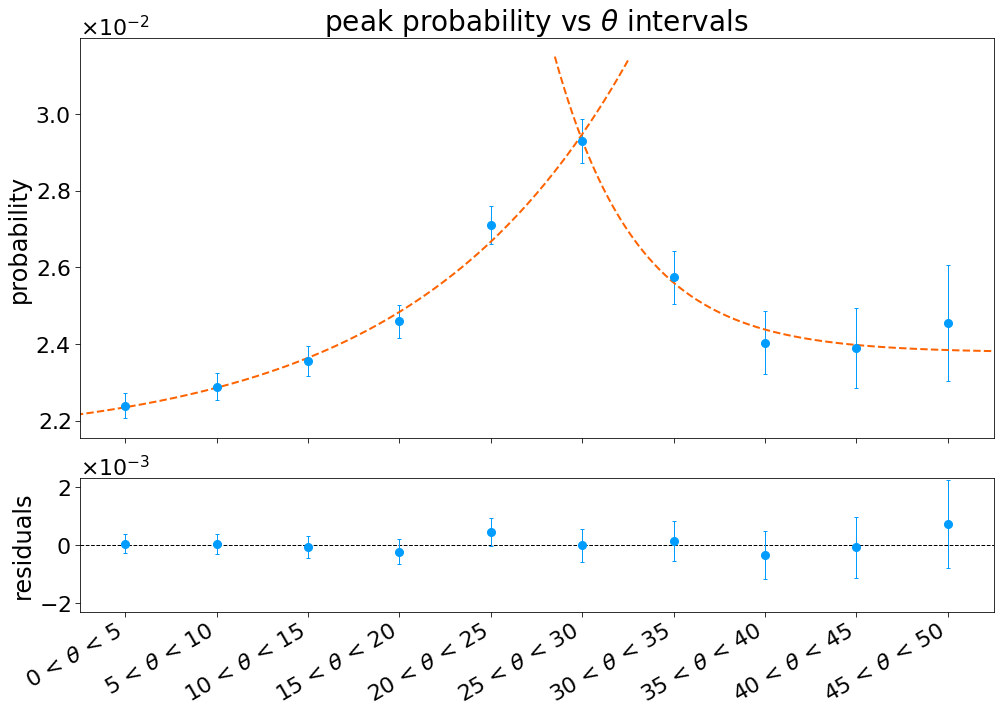

In [43]:
def expo(x, a, b, c):
    return a+b*np.exp(c*x)

def nexpo(x, a, b, c):
    return a+b*np.exp(-c*x)



thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
x_theta = np.linspace(-5,27.5,500)


xlabels = [r"%i < $\theta$ < %i"%(x1,x2) for x1, x2 in zip(thetas_low,thetas_up)]


fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs $\theta$ intervals")
ax1.set_ylabel("probability")
ax2.set_ylabel("residuals")
ax1.set_xticks(thetas_low)
ax2.set_xticks(thetas_low)
ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(-2.5, 47.5)
ax2.set_xlim(-2.5, 47.5)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

ax1.errorbar(
    x=thetas_low, 
    y=middle_peaks, 
    yerr=middle_peaks_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2
)

# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=expo, 
    xdata=thetas_low[:6], 
    ydata=middle_peaks[:6], 
    sigma=middle_peaks_err[:6], 
    absolute_sigma=True
)

# residuals
func = expo(np.array(thetas_low[:6]), *middle_par_tot)
middle_res = middle_peaks[:6] - func
chi_middle_large = np.sum( ( middle_res ) / middle_peaks_err[:6] )**2


#  residuals
ax2.errorbar(
    x          = thetas_low[:5], 
    y          = middle_res[:5],
    yerr       = middle_peaks_err[:5],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)


ax1.plot(
    x_theta, 
    expo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)

# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=nexpo, 
    xdata=thetas_low[5:], 
    ydata=middle_peaks[5:], 
    sigma=middle_peaks_err[5:], 
    absolute_sigma=True
)

# residuals
func = nexpo(np.array(thetas_low[5:]), *middle_par_tot)
middle_res = middle_peaks[5:] - func
chi_middle_small = np.sum( ( middle_res ) / middle_peaks_err[5:] )**2


#  residuals
ax2.errorbar(
    x          = thetas_low[5:], 
    y          = middle_res,
    yerr       = middle_peaks_err[5:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

x_theta = np.linspace(23.5,47.5,500)

ax1.plot(
    x_theta, 
    nexpo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)

ax2.set_ylim(-2.3e-3,2.3e-3)

fig.tight_layout()

PLOT_NAME = "intervals_fit"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

In [40]:
# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
middle_r,   middle_p = scipy.stats.pearsonr(thetas_low, middle_peaks)

print("\nmiddle CUT:")
print(f"Correlation coefficient {middle_r:.5f}")
print(f"p-value = {middle_p:.2e}")
print("Statistically significant:", "YES" if middle_p < alpha else "NO")

print("chi squared", chi_middle_small)
print("chi squared", chi_middle_large)




middle CUT:
Correlation coefficient 0.30452
p-value = 3.92e-01
Statistically significant: NO
chi squared 0.027399364442299293
chi squared 0.00010661023008085008


In [41]:
# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
middle_r,   middle_p = scipy.stats.pearsonr(thetas_low[:4], middle_peaks[:4])

print("\nmiddle CUT:")
print(f"Correlation coefficient {middle_r:.5f}")
print(f"p-value = {middle_p:.2e}")
print("Statistically significant:", "YES" if middle_p < alpha else "NO")



middle CUT:
Correlation coefficient 0.98580
p-value = 1.42e-02
Statistically significant: YES


In [20]:
from scipy.optimize import curve_fit

def lorentzian(x, A, x0, gamma):
    return A*gamma**2/(gamma**2+(x-x0)**2)

def gaussian(x, A , mean , std ):
    return A * np.exp( - ((x - mean) **2 /(2*std**2)))

x=np.linspace(0,100, 35)
bins = np.linspace(-90, 490, 100)
xx=np.linspace(x[0], x[-1], 1000)

# stima picchi con gauss

0.02389 pm 0.00013
0.02231 pm 0.00013
0.02306 pm 0.00011
0.02280 pm 0.00011
0.02414 pm 0.00009
0.02393 pm 0.00010
0.02408 pm 0.00010
0.02485 pm 0.00008
0.02484 pm 0.00008
0.02484 pm 0.00008


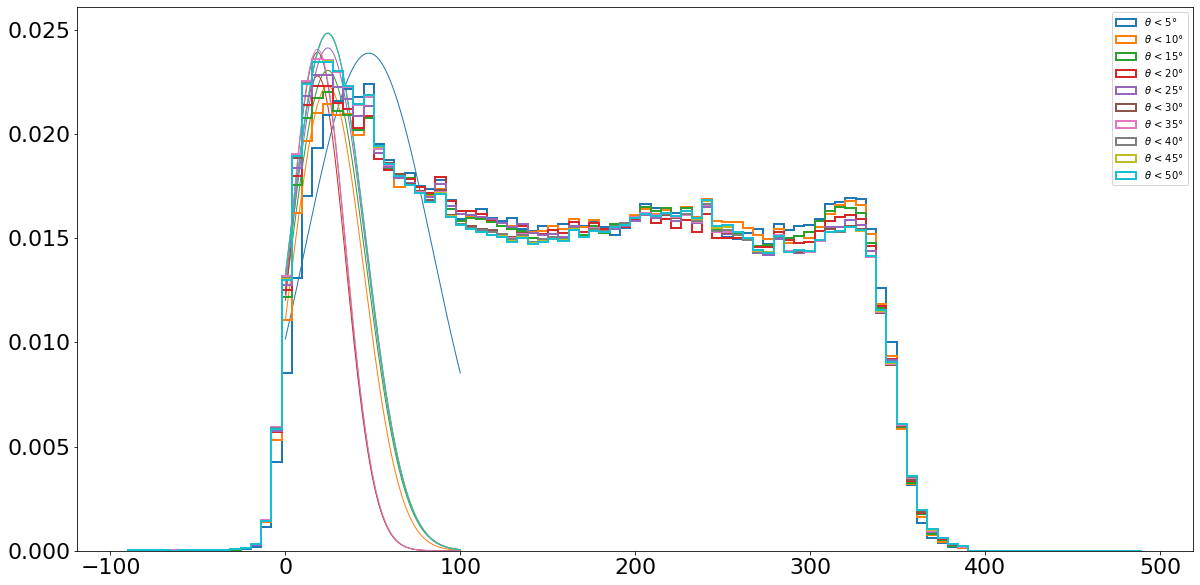

In [21]:
fig, ax = plt.subplots(figsize=(20,10))

gauss_low_peaks = []
lor_low_peaks = []
low_params=[]
gauss_low_err = []

# for p,b,err in zip(low_hists[1:2], low_hist_bins[1:2], low_err[1:2]):
for p,b,err in zip(low_hists, low_hist_bins, low_err):
   
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df.dropna(axis=0)
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )
    # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_low_peaks.append( y_gauss.max() )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_low_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1)
    
    bound_upper = gaussian(xx, *(popt_gauss + sigma))
    bound_lower = gaussian(xx, *(popt_gauss - sigma))
    # plotting the confidence intervals
    # ax.fill_between(xx, bound_lower, bound_upper, alpha = 1, color='black')

# for h, theta in zip(low_hists[1:2], thetas[1:2]):
for h, theta in zip(low_hists, thetas):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        lw=2,
        label=r"$\theta$ < "+str(theta)+"°"
    )
    # ax.scatter(final_df['bin_cent'], final_df['prob'], color='red')
    # ax.errorbar(x=final_df['bin_cent'], y=final_df['prob'], yerr=final_df['err'],
    #     marker     = "o",
    #     color      =  "black",
    #     linestyle  = "none",
    #     elinewidth = 1, 
    #     capsize    = 2, )

ax.legend()

for p,e in zip(gauss_low_peaks, gauss_low_err):
    print(f'{p:.5f} pm {e:.5f}')



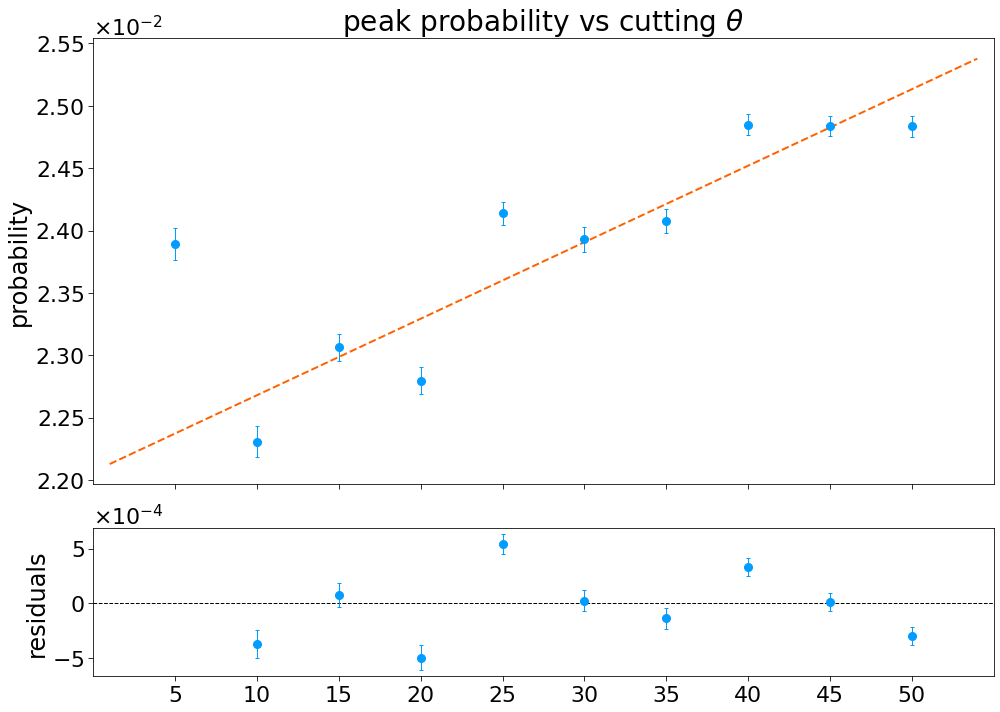

In [54]:
gauss_par, _ = curve_fit(
    f=lin,
    xdata=thetas[1:], 
    ydata=gauss_low_peaks[1:],
    sigma=gauss_low_err[1:],
    absolute_sigma=True
)

fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs cutting $\theta$")
ax1.set_ylabel("probability")
ax2.set_ylabel("residuals")
# ax1.set_xticks(thetas_low)
ax1.set_xticks(thetas)
ax2.set_xticks(thetas)
# ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(0, 55)
ax2.set_xlim(0, 55)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)
# ax.set_xlim(theta_grid[0], theta_grid[-1])

ax1.plot(
    theta_grid, 
    lin(theta_grid, *gauss_par),
    linestyle = "dashed",
    color = "#ff6300", 
    lw=2,
)

ax1.errorbar(
    x          = thetas, 
    y          = gauss_low_peaks,
    yerr       = gauss_low_err,
    marker     = "o",
    color      =  "#009cff",
    markersize = 8,
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)

#residuals
func = lin(np.array(thetas[1:]), *gauss_par)
low_res = gauss_low_peaks[1:] - func
chi_low = np.sum( ( low_res ) / gauss_low_err[1:] )**2

#  residuals
ax2.errorbar(
    x          = thetas[1:], 
    y          = low_res,
    yerr       = gauss_low_err[1:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

fig.tight_layout()
PLOT_NAME = "gaus_fit_low"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

In [45]:
high_r, high_p = scipy.stats.pearsonr(thetas[1:], gauss_low_peaks[1:])
# high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)

print(f"Correlation coefficient {high_r:.5f}")
print('Chi squared', chi_low)
print(f"p-value = {high_p:.2e}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

Correlation coefficient 0.93778
Chi squared 103.9238633605301
p-value = 1.86e-04
Statistically significant: YES


# Taglio sopra

0.02578 pm 0.00010
0.02630 pm 0.00012
0.02684 pm 0.00014
0.02874 pm 0.00013
0.02779 pm 0.00019
0.02694 pm 0.00024
0.02857 pm 0.00023
0.02948 pm 0.00036
0.03167 pm 0.00043
0.03322 pm 0.00048


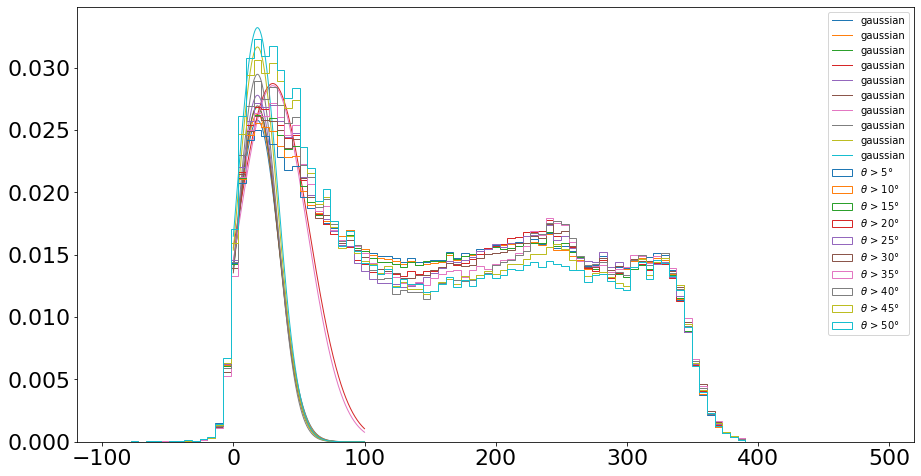

In [55]:
fig, ax = plt.subplots(figsize=(15,8))

gauss_up_peaks = []
lor_up_peaks = []
gauss_up_err = []

for p,b,err in zip(high_hists, high_hist_bins, high_err ):
    
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df[ final_df['prob']!=0 ]
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )
    # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_up_peaks.append( y_gauss.max() )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_up_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')


for h, theta in zip(high_hists, thetas):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ > "+str(theta)+"°"
    )
    # ax.scatter(final_df['bin_cent'], final_df['prob'])

ax.legend()

for p,e in zip(gauss_up_peaks, gauss_up_err):
    print(f'{p:.5f} pm {e:.5f}')


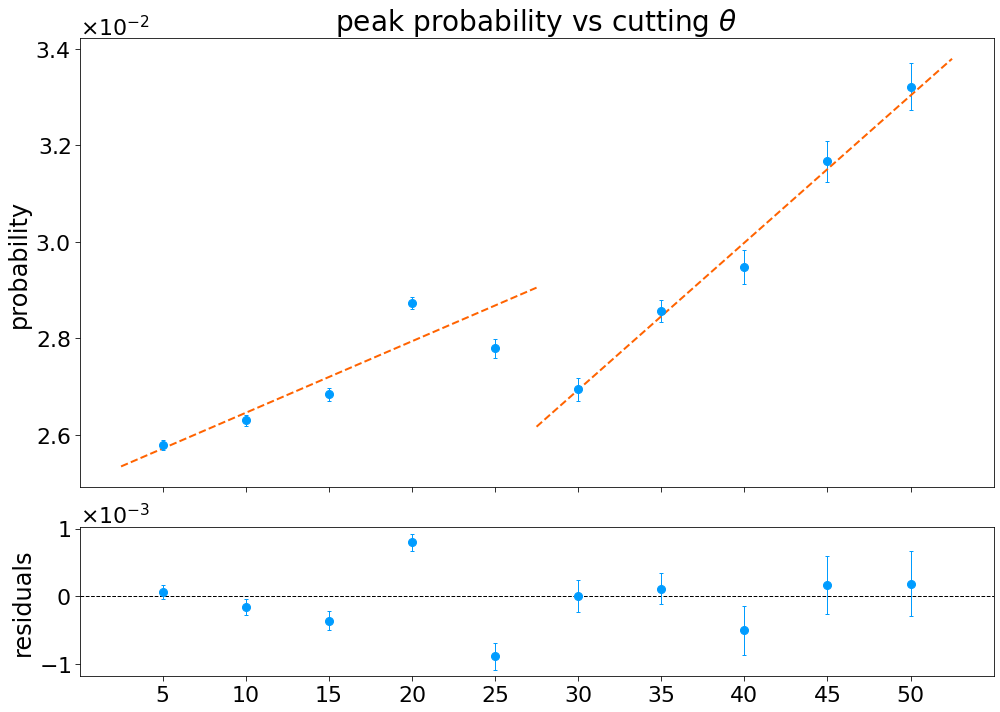

In [56]:
fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs cutting $\theta$")
ax1.set_ylabel("probability")
ax2.set_ylabel("residuals")
# ax1.set_xticks(thetas_low)
ax1.set_xticks(thetas)
ax2.set_xticks(thetas)
# ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(0, 55)
ax2.set_xlim(0, 55)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)


gauss_high_par, _ = curve_fit(
    f=lin,
    xdata=thetas[:5], 
    ydata=gauss_up_peaks[:5],
    sigma=gauss_up_err[:5],
    absolute_sigma=True
)


func = lin(np.array(thetas[0:5]), *gauss_high_par)
high_res = gauss_up_peaks[0:5] - func
chi_high_small = np.sum( ( high_res ) / gauss_up_err[0:5] )**2

theta_grid = np.linspace(thetas[0]-2.5, thetas[4]+2.5, 500)
ax1.plot(
    theta_grid, 
    lin(theta_grid, *gauss_high_par),
    linestyle = "dashed",
    color = "#ff6300", 
    lw=2,
)

ax1.errorbar(
    x          = thetas, 
    y          = gauss_up_peaks,
    yerr       = gauss_up_err,
    marker     = "o",
    color      =  "#009cff",
    markersize = 8,
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)

#  residuals
ax2.errorbar(
    x          = thetas[:5], 
    y          = high_res,
    yerr       = gauss_up_err[:5],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)


gauss_high_par, _ = curve_fit(
    f=lin,
    xdata=thetas[5:], 
    ydata=gauss_up_peaks[5:],
    sigma=gauss_up_err[5:],
    absolute_sigma=True
)

func = lin(np.array(thetas[5:]), *gauss_high_par)
high_res = gauss_up_peaks[5:] - func
chi_high_large = np.sum( ( high_res ) / gauss_up_err[5:] )**2

theta_grid = np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 500)
ax1.plot(
    theta_grid, 
    lin(theta_grid, *gauss_high_par),
    linestyle = "dashed",
    color = "#ff6300", 
    lw=2,
)

#  residuals
ax2.errorbar(
    x          = thetas[5:], 
    y          = high_res,
    yerr       = gauss_up_err[5:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

fig.tight_layout()
PLOT_NAME = "gaus_fit_high"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

In [39]:
low_r, low_p = scipy.stats.pearsonr(thetas[0:5], gauss_up_peaks[0:5])
high_r, high_p = scipy.stats.pearsonr(thetas[5:], gauss_up_peaks[5:])

print(f"Correlation coefficient {low_r:.5f}")
print('Chi squared', chi_high_small)
print(f"p-value = {low_p:.2e}")
print("Statistically significant:", "YES" if low_p < alpha else "NO")

print(f"Correlation coefficient {high_r:.5f}")
print('Chi squared', chi_high_large)
print(f"p-value = {high_p:.2e}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

Correlation coefficient 0.86299
Chi squared 2.982611841049203
p-value = 5.96e-02
Statistically significant: NO
Correlation coefficient 0.99369
Chi squared 0.016592917972040294
p-value = 6.02e-04
Statistically significant: YES


In [49]:
# # thetas_low = [0,10,20,30]
# # thetas_up = [10,20,30,40]
# # thetas_low = [0,5,10,15,20,25,30,35]
# # thetas_up = [5,10,15,20,25,30,35,40]

# # middle_cut = [ ( (np.abs(df["theta"]) > low ) & (np.abs(df["theta"]) < up ) ) for low,up in zip(thetas_low,thetas_up) ]

# gauss_middle_peaks = []
# gauss_middle_err = []

# fig, ax = plt.subplots(figsize=(15,8))

# for cut in middle_cut:
#     df_prova = df[ cut ]
#     p, b = np.histogram(df_prova.drift_time, bins=bins)
#     p_norm = normalize(p)
#     bin_centers = (b[1:]+b[:-1])/2

#     #incertezze sulle y cioè sulle probabilità:
#     norm = sum(p)
#     err = [np.sqrt(h / norm) for h in p_norm] #errore su tutti i p

#     DF = pd.DataFrame({'prob':p_norm, 'bin_cent':bin_centers, 'err':err})
#     DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
#     DF = DF.reset_index(drop=True)

#     prob_peak = DF['prob'].max()
#     bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
#     err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

#     first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
#     prob_first_half =  first_half_df['prob']
#     err_first_half = first_half_df['err']

#     bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

#     second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
#     second_half_df.columns = ['prob', 'bin_cent', 'err']
#     second_half_df['prob'] = second_half_df['prob'].values[::-1]
#     second_half_df['err'] = second_half_df['err'].values[::-1]

#     first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
#     final_df = first_half_df.append(second_half_df, ignore_index=True)
#     final_df = final_df[ final_df['prob']!=0 ]
    
#     popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
#     p0=[0.02, 20, 10], 
#     sigma=final_df['err'], 
#     absolute_sigma=True
#     )
#     # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

#     y_gauss = gaussian(xx,*popt_gauss)
#     gauss_middle_peaks.append( y_gauss.max() )

#     sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
#     #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
#     gauss_middle_err.append(sigma[0])
#     ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')
#     ax.scatter(DF['bin_cent'], DF['prob'])

#     break

# for h, theta_low, theta_up in zip(middle_norm_hist, thetas_low,thetas_up,):
#     ax.hist(
#         bins[:-1],
#         bins=bins,
#         weights=h,
#         histtype="step",
#         linewidth = 2,
#         label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
#     )
#     # ax.scatter(final_df['bin_cent'], final_df['prob'])

#     break
# ax.legend()

# # for p,e in zip(gauss_low_peaks, gauss_low_err):
# #     print(f'{p:.5f} pm {e:.5f}')


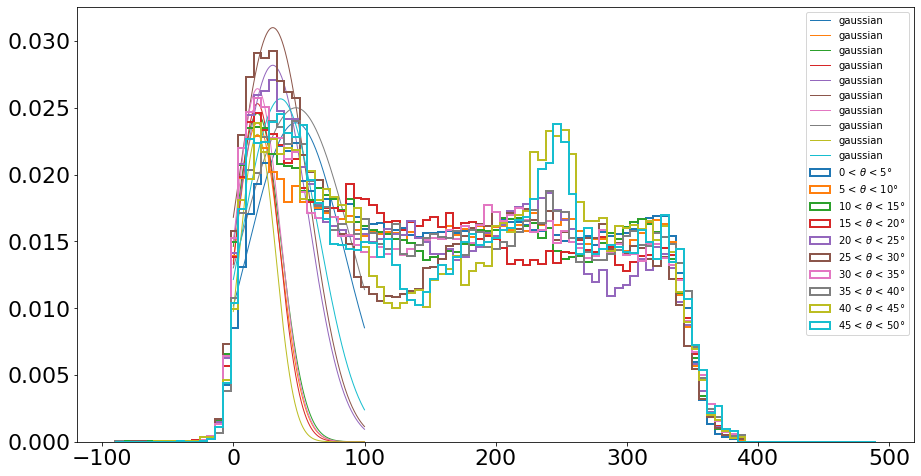

In [57]:
gauss_middle_peaks = []
gauss_middle_err = []

fig, ax = plt.subplots(figsize=(15,8))

for p,b,err in zip(middle_norm_hist, middle_hist_bins, middle_err ):
    
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df[ final_df['prob']!=0 ]
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )
    # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_middle_peaks.append( y_gauss.max() )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_middle_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')
    
    # ax.scatter(DF['bin_cent'], DF['prob'])
    # break

for h, theta_low, theta_up in zip(middle_norm_hist, thetas_low, thetas_up,):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
    )
    # ax.scatter(final_df['bin_cent'], final_df['prob'])
    # break
ax.legend()



/var/folders/q3/r96zncz17lq5z2jf1vj44c700000gn/T/ipykernel_22547/122210048.py:5: RuntimeWarning: overflow encountered in exp
  return a+b*np.exp(-c*x)


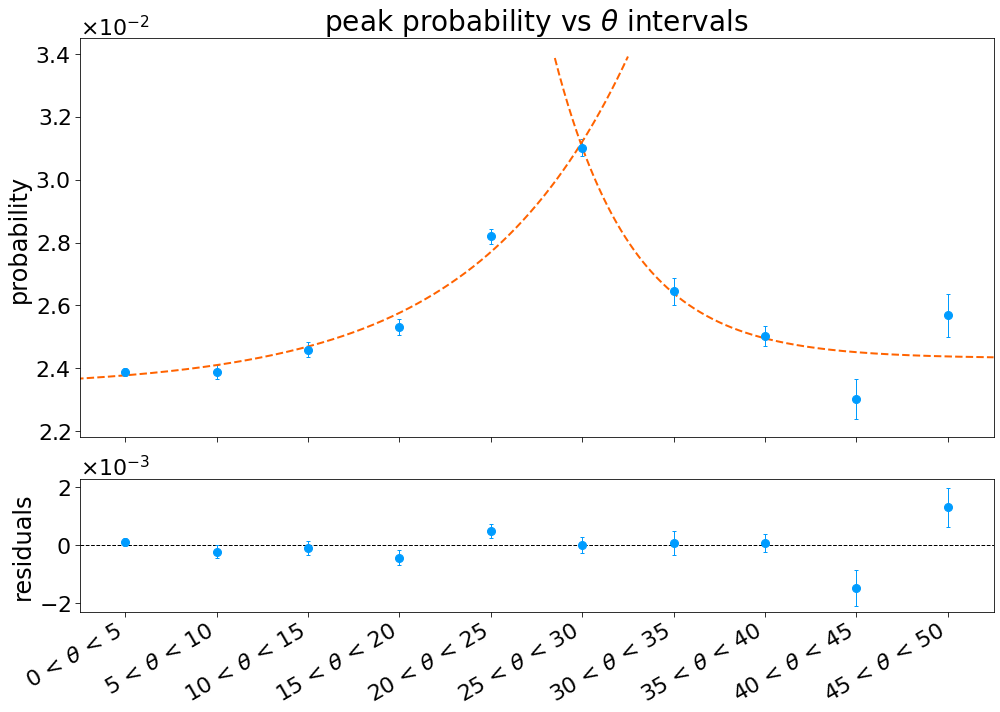

In [58]:
def expo(x, a, b, c):
    return a+b*np.exp(c*x)

def nexpo(x, a, b, c):
    return a+b*np.exp(-c*x)



thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
x_theta = np.linspace(-5,27.5,500)


xlabels = [r"%i < $\theta$ < %i"%(x1,x2) for x1, x2 in zip(thetas_low,thetas_up)]


fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs $\theta$ intervals")
ax1.set_ylabel("probability")
ax2.set_ylabel("residuals")
ax1.set_xticks(thetas_low)
ax2.set_xticks(thetas_low)
ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(-2.5, 47.5)
ax2.set_xlim(-2.5, 47.5)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

ax1.errorbar(
    x=thetas_low, 
    y=gauss_middle_peaks, 
    yerr=gauss_middle_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2
)

# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=expo, 
    xdata=thetas_low[:6], 
    ydata=gauss_middle_peaks[:6], 
    sigma=gauss_middle_err[:6], 
    absolute_sigma=True
)

# residuals
func = expo(np.array(thetas_low[:6]), *middle_par_tot)
middle_res = gauss_middle_peaks[:6] - func
chi_middle_large = np.sum( ( middle_res ) / gauss_middle_err[:6] )**2


#  residuals
ax2.errorbar(
    x          = thetas_low[:5], 
    y          = middle_res[:5],
    yerr       = gauss_middle_err[:5],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)


ax1.plot(
    x_theta, 
    expo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)

# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=nexpo, 
    xdata=thetas_low[5:], 
    ydata=gauss_middle_peaks[5:], 
    sigma=gauss_middle_err[5:], 
    absolute_sigma=True
)

# residuals
func = nexpo(np.array(thetas_low[5:]), *middle_par_tot)
middle_res = gauss_middle_peaks[5:] - func
chi_middle_small = np.sum( ( middle_res  / gauss_middle_err[5:] )**2 )


#  residuals
ax2.errorbar(
    x          = thetas_low[5:], 
    y          = middle_res,
    yerr       = gauss_middle_err[5:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

x_theta = np.linspace(23.5,47.5,500)

ax1.plot(
    x_theta, 
    nexpo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)

ax2.set_ylim(-2.3e-3,2.3e-3)

fig.tight_layout()

PLOT_NAME = "gaus_intervals_fit"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

In [50]:

high_r, high_p = scipy.stats.pearsonr(thetas_low, gauss_middle_peaks)
# high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)

print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.4f}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

print("chi squared", chi_middle_small)
print("chi squared", chi_middle_large)



Correlation coefficient 0.14255
p-value = 0.6944
Statistically significant: NO
chi squared 9.478315256877089
chi squared 0.7599772747325497
